<a href="https://colab.research.google.com/github/TarkanAl-Kazily/awbw_replay_parser/blob/main/AWBW_Replays_Interactive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to my AWBW Replay Parser project!

This interactive notebook will introduce you to the replay parsing library, and demonstrate how to use it to learn more about your matches.

This notebook and the source code is all hosted on Github here: [https://github.com/TarkanAl-Kazily/awbw_replay_parser](https://github.com/TarkanAl-Kazily/awbw_replay_parser)

## Prerequisites

You will need need to have an AWBW Replay file that conforms to the newer .zip replay format. To access AWBW Replays, you must have an AWBW account and download them before they are deleted from the site. Because an account is required, it's currently not possible to automatically download replays through this notebook. Older replays _might_ work, but the results may be inaccurate.

Ideally to fully use this notebook, you have some familiarity with Python and matplotlib to to customize the displayed data from your replay. If you wish to contribute and make changes to this notebook or the repo itself, you will need a Github account and make a pull request (following the [contribution guide](https://github.com/TarkanAl-Kazily/awbw_replay_parser/blob/main/CONTRIBUTING.md)).


## Notebook Setup

In order to use the `awbw_replay_parser` code from Google Colab, we first have to clone the repository and install any missing Python modules. This block only needs to be ran once.

__IMPORTANT__: Restart the kernel after running this step - __Runtime -> Restart Runtime__ or __Ctrl+M+.__

If you need to install any additional Python modules, you can do so directly here with `!pip install <module>`. Note that at the time of writing, Google Colab's Python kernel version is fixed to Python 3.7.

You should be able to safely restart the Python kernel at anytime afterwards without needing to rerun this step. You only need to rerun this step if you want to pull updated changes from the Github repository.

In [2]:
# TODO: Remove the Token steps when the Repo is made public

from getpass import getpass
import os

TOKEN = getpass('Enter Github User Token:')
os.environ['TOKEN'] = TOKEN
os.environ['REPO'] = "github.com/TarkanAl-Kazily/awbw_replay_parser.git"
os.environ['BRANCH'] = "main"

# Clone the awbw_replay_parser repository
!cd /content/
!rm -rf awbw_replay_parser
!git clone --branch $BRANCH https://$TOKEN@$REPO
!pip install -r awbw_replay_parser/requirements.txt

# Install the awbw_replay module into our runtime
!cd awbw_replay_parser && python setup.py install

Enter Github User Token:··········
Cloning into 'awbw_replay_parser'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 204 (delta 100), reused 126 (delta 46), pack-reused 0
Receiving objects: 100% (204/204), 312.56 KiB | 3.96 MiB/s, done.
Resolving deltas: 100% (100/100), done.
     |████████████████████████████████| 11.2 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 39.7 MB/s 
     |████████████████████████████████| 890 kB 52.2 MB/s 
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=95a512d72954a81a773dcd191fc0f6b3b7ce2088e85205b2885b188e08739a73
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for phpserialize: filename=phpserialize-1.3-py3-none-any.whl size=9491 sha256=7d9c90e80fb491e561ab7bf682016217658ef0b2f47b58d0783233080363633f
  Stored in directory: /r

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/awbw_replay
copying awbw_replay/replay.py -> build/lib/awbw_replay
copying awbw_replay/test_game.py -> build/lib/awbw_replay
copying awbw_replay/awbw.py -> build/lib/awbw_replay
copying awbw_replay/test_awbw.py -> build/lib/awbw_replay
copying awbw_replay/test_replay.py -> build/lib/awbw_replay
copying awbw_replay/__init__.py -> build/lib/awbw_replay
copying awbw_replay/game.py -> build/lib/awbw_replay
running install_lib
creating /usr/local/lib/python3.7/dist-packages/awbw_replay
copying build/lib/awbw_replay/replay.py -> /usr/local/lib/python3.7/dist-packages/awbw_replay
copying build/lib/awbw_replay/test_game.py -> /usr/local/lib/python3.7/dist-packages/awbw_replay
copying build/lib/awbw_replay/awbw.py -> /usr/local/lib/python3.7/dist-packages/awbw_replay
copying

## Parsing a Replay

Now that the codebase is downloaded and the notebook is setup, we can start analyzing replays. To analyze your own replay, use the sidebar and upload your replay (in its original `.zip` format). Alternatively, there are a few example replays included in the repository under `awbw_replay_parser/replays/`. With Google Colab, you can also mount your Google Drive to access cloud files directly.

Resign action
IMPLEMENT ME


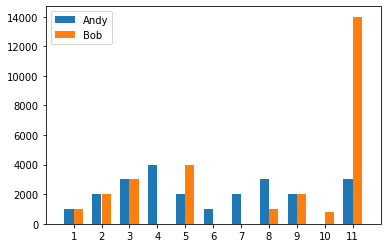

In [1]:
import awbw_replay.awbw as awbw
import awbw_replay.replay as replay
import sys
sys.path.append("awbw_replay_parser")
import main

with replay.AWBWReplay("awbw_replay_parser/replays/standard_replay.zip") as replay:
  main.test_replay(replay, show_plot=True)
